In [3]:
import geopandas as gpd
import rasterio
import xarray
import leafmap
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
print("All libraries imported successfully!")


All libraries imported successfully!


In [4]:
m = leafmap.Map(center=[40, -100], zoom=4, height="500px")

m.add_basemap("OpenTopoMap")
m.add_basemap("USGS.Imagery")

m

Map(center=[40, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [5]:
#create a GeoPandas GeoDataFrame
data = {
    "City": ["Tokyo", "New York", "London", "Paris"],
    "Latitude": [35.6895, 40.7128, 51.5074, 48.8566],
    "Longitude": [139.6917, -74.0060, -0.1278, 2.3522]
}
#firstly we create the regular pandas DataFrame
df = pd.DataFrame(data)
#then we convert it to a GeoDataFrame by creating Point geometries from coordinates lat and lon pairs
gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.Longitude,df.Latitude))
gdf

City  Latitude  Longitude                  geometry
0     Tokyo   35.6895   139.6917  POINT (139.6917 35.6895)
1  New York   40.7128   -74.0060   POINT (-74.006 40.7128)
2    London   51.5074    -0.1278   POINT (-0.1278 51.5074)
3     Paris   48.8566     2.3522    POINT (2.3522 48.8566)

In [6]:
#Reading a GeoJSON File
url = "https://github.com/opengeos/datasets/releases/download/vector/nybb.geojson"
gdf = gpd.read_file(url)
gdf.head()

ERROR 1: /lib/x86_64-linux-gnu/libstdc++.so.6: version `CXXABI_1.3.15' not found (required by /app/workspace/miniconda3/envs/gispro/lib/gdalplugins/../libgdal.so.36)
ERROR 1: /lib/x86_64-linux-gnu/libstdc++.so.6: version `CXXABI_1.3.15' not found (required by /app/workspace/miniconda3/envs/gispro/lib/gdalplugins/../libgdal.so.36)
ERROR 1: /lib/x86_64-linux-gnu/libstdc++.so.6: version `CXXABI_1.3.15' not found (required by /app/workspace/miniconda3/envs/gispro/lib/gdalplugins/../libgdal.so.36)
ERROR 1: /lib/x86_64-linux-gnu/libstdc++.so.6: version `CXXABI_1.3.15' not found (required by /app/workspace/miniconda3/envs/gispro/lib/gdalplugins/../libgdal.so.36)
ERROR 1: /lib/x86_64-linux-gnu/libstdc++.so.6: version `CXXABI_1.3.15' not found (required by /app/workspace/miniconda3/envs/gispro/lib/gdalplugins/gdal_netCDF.so)
ERROR 1: /lib/x86_64-linux-gnu/libstdc++.so.6: version `CXXABI_1.3.15' not found (required by /app/workspace/miniconda3/envs/gispro/lib/gdalplugins/gdal_netCDF.so)


BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  330470.010332  1.623820e+09   
1         4         Queens  896344.047763  3.045213e+09   
2         3       Brooklyn  741080.523166  1.937479e+09   
3         1      Manhattan  359299.096471  6.364715e+08   
4         2          Bronx  464392.991824  1.186925e+09   

                                            geometry  
0  MULTIPOLYGON (((970217.022 145643.332, 970227....  
1  MULTIPOLYGON (((1029606.077 156073.814, 102957...  
2  MULTIPOLYGON (((1021176.479 151374.797, 102100...  
3  MULTIPOLYGON (((981219.056 188655.316, 980940....  
4  MULTIPOLYGON (((1012821.806 229228.265, 101278...

In [7]:
#writing geospatial data allows us to save work in different formats which provides flexibility
#for sharing data with different software systems
output_file = "nyc_boroughs.geojson"
gdf.to_file(output_file,driver= "GeoJSON")
print(f"GeoDataFrame has been writte nto {output_file}")


GeoDataFrame has been writte nto nyc_boroughs.geojson


In [8]:
#saving into different formats like Shapefile, the traditional GIS-format and GeoPackage, the modern, single-file format)
output_file = "nyc_boroughs.shp"
gdf.to_file(output_file)
print(f"GeoDataFram has been written tp {output_file}")

output_file = "nyc_boroughs.gpkg"
gdf.to_file(output_file,driver="GPKG")
print(f"GeoDataFrame has been written to {output_file} as a type 'GeoPackage'\n")

GeoDataFram has been written tp nyc_boroughs.shp
GeoDataFrame has been written to nyc_boroughs.gpkg as a type 'GeoPackage'



 <span style="font-size:20px"> Now we try understanding coordinate ueference uystems</span> 

In [9]:
print(f"Current CRS: {gdf.crs}")

#time to reproject to globally compatible WGS84
gdf_4326 = gdf.to_crs(epsg=4326)
print(f"Reporjected CRS: {gdf_4326.crs}")
gdf_4326.head()

Current CRS: EPSG:2263
Reporjected CRS: EPSG:4326


BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  330470.010332  1.623820e+09   
1         4         Queens  896344.047763  3.045213e+09   
2         3       Brooklyn  741080.523166  1.937479e+09   
3         1      Manhattan  359299.096471  6.364715e+08   
4         2          Bronx  464392.991824  1.186925e+09   

                                            geometry  
0  MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...  
1  MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ...  
2  MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...  
3  MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...  
4  MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...

Neat, now we see how the geometry feature shows coordinates in degrees rader than feet whicch EPSG:2263 used to have

 <span style="font-size:20px">That's cool and all but we need this for creating meaningful area measurements:</span> 

In [10]:
gdf["area"] = gdf.area

gdf["area_km2"] = gdf["area"] / 1_000_000

gdf[["area","area_km2"]].sort_values("area_km2", ascending=False) #sort the boroughs by area_km2 in descending order
gdf.head()

BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  330470.010332  1.623820e+09   
1         4         Queens  896344.047763  3.045213e+09   
2         3       Brooklyn  741080.523166  1.937479e+09   
3         1      Manhattan  359299.096471  6.364715e+08   
4         2          Bronx  464392.991824  1.186925e+09   

                                            geometry          area  \
0  MULTIPOLYGON (((970217.022 145643.332, 970227....  1.623822e+09   
1  MULTIPOLYGON (((1029606.077 156073.814, 102957...  3.045214e+09   
2  MULTIPOLYGON (((1021176.479 151374.797, 102100...  1.937478e+09   
3  MULTIPOLYGON (((981219.056 188655.316, 980940....  6.364712e+08   
4  MULTIPOLYGON (((1012821.806 229228.265, 101278...  1.186926e+09   

      area_km2  
0  1623.821997  
1  3045.213694  
2  1937.478349  
3   636.471238  
4  1186.926294

Let's extract some geometric features

In [11]:
gdf["boundary"] = gdf.boundary #extracts boundary lines from the polygons

gdf["centroid"] = gdf.centroid #calculates geometric centers

#display the features
gdf[["boundary", "centroid"]].head()

boundary  \
0  MULTILINESTRING ((970217.022 145643.332, 97022...   
1  MULTILINESTRING ((1029606.077 156073.814, 1029...   
2  MULTILINESTRING ((1021176.479 151374.797, 1021...   
3  MULTILINESTRING ((981219.056 188655.316, 98094...   
4  MULTILINESTRING ((1012821.806 229228.265, 1012...   

                         centroid  
0    POINT (941639.45 150931.991)  
1  POINT (1034578.078 197116.604)  
2   POINT (998769.115 174169.761)  
3   POINT (993336.965 222451.437)  
4    POINT (1021174.79 249937.98)

In [12]:
# Check column names and values
print("columns:", list(gdf.columns))
print("unique BoroName values:", gdf['BoroName'].unique())

# Normalize BoroName for matching
gdf['boro_clean'] = gdf['BoroName'].astype(str).str.strip().str.lower()

# Ensure we have a CRS and use a metric projection for distance (EPSG:3857)
if gdf.crs is None:
    raise RuntimeError("gdf.crs is None — set a CRS before distance calculations")
if gdf.crs.is_geographic:
    gdf = gdf.to_crs(epsg=3857)

# Create centroids in the projected CRS
gdf['centroid'] = gdf.geometry.centroid

# Create boolean mask and check it
mask = gdf['boro_clean'] == 'manhattan'
if not mask.any():
    raise KeyError(f"No row matched 'manhattan'. Available: {gdf['boro_clean'].unique()}")

# Get Manhattan centroid and compute distances (meters -> kilometers)
manhattan_centroid = gdf.loc[mask, 'centroid'].iloc[0]
gdf['distance_to_manhattan_m'] = gdf['centroid'].distance(manhattan_centroid)
gdf['distance_to_manhattan_km'] = gdf['distance_to_manhattan_m'] / 1000

# Show results
gdf[['BoroName', 'distance_to_manhattan_km']].sort_values('distance_to_manhattan_km')

columns: ['BoroCode', 'BoroName', 'Shape_Leng', 'Shape_Area', 'geometry', 'area', 'area_km2', 'boundary', 'centroid']
unique BoroName values: ['Staten Island' 'Queens' 'Brooklyn' 'Manhattan' 'Bronx']


BoroName  distance_to_manhattan_km
3      Manhattan                  0.000000
4          Bronx                 39.121024
1         Queens                 48.401272
2       Brooklyn                 48.586299
0  Staten Island                 88.247743

In [13]:
import matplotlib.pyplot as plt
# Set high resolution for better quality plots
plt.rcParams["figure.dpi"] = 150

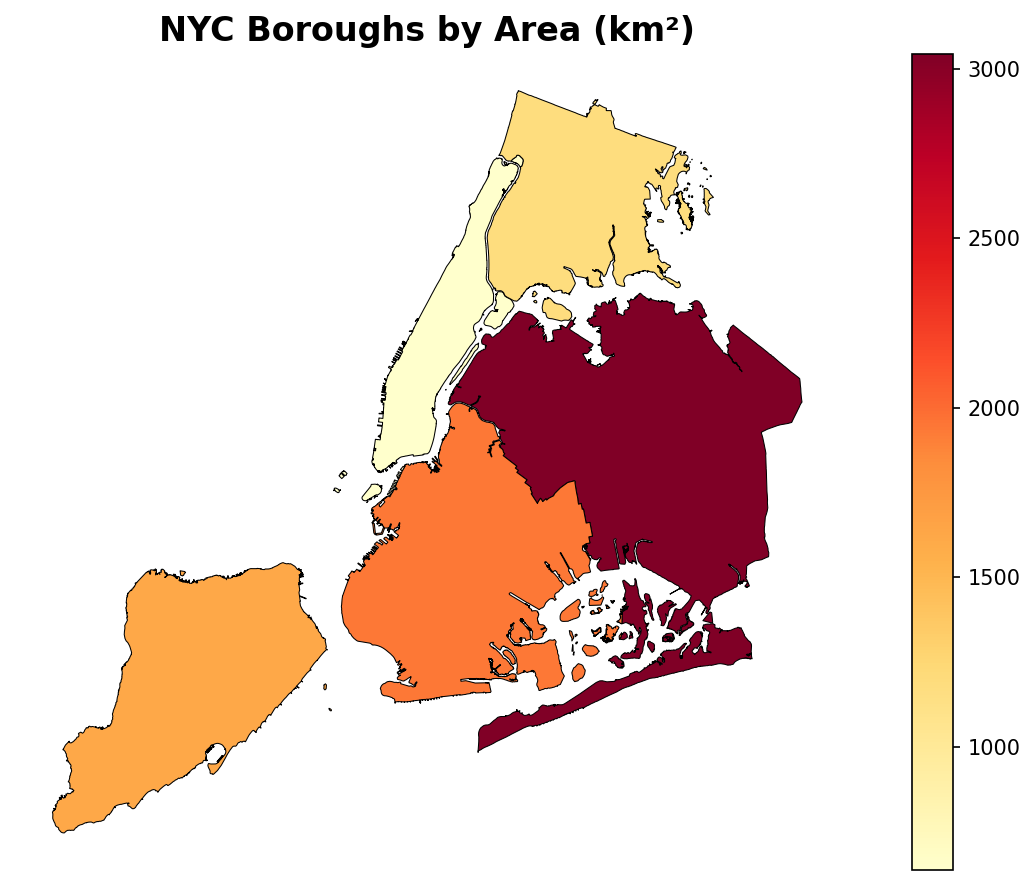

In [14]:
# Create a choropleth map showing borough areas
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(
column="area_km2",
ax=ax,
legend=True,
cmap="YlOrRd", # Yellow-Orange-Red colormap
edgecolor="black",
linewidth=0.5,
)
plt.title("NYC Boroughs by Area (km²)", fontsize=16, fontweight="bold")
plt.axis("off") # Remove coordinate axes for cleaner appearance
plt.tight_layout()
plt.show()

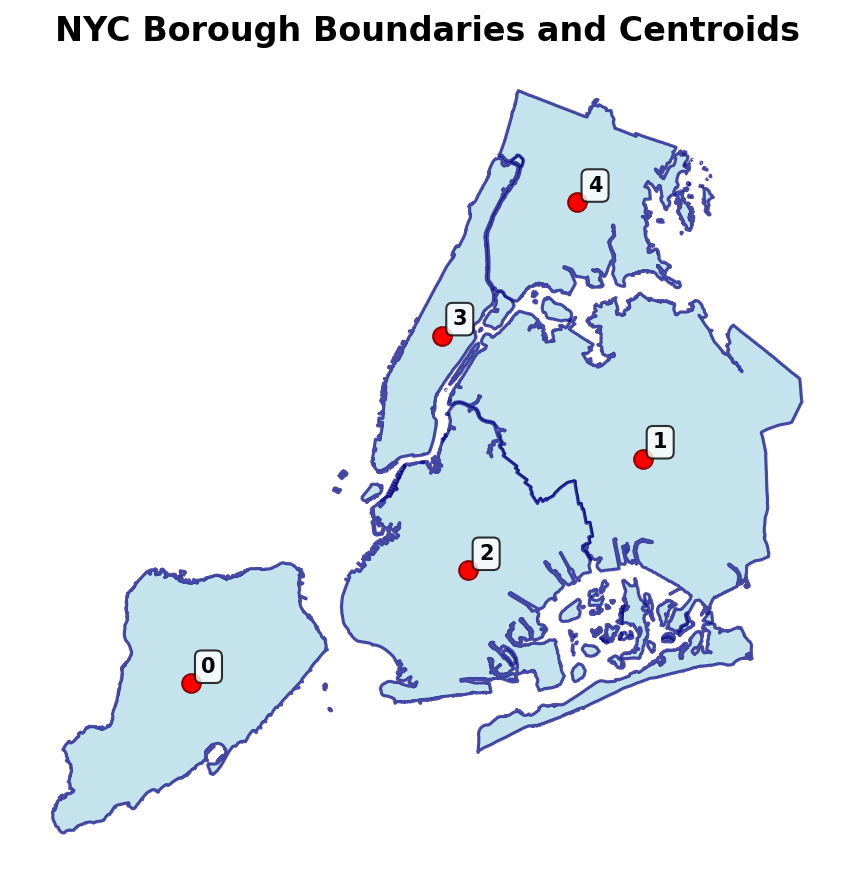

In [15]:
# Create a comprehensive map with multiple layers
fig, ax = plt.subplots(figsize=(10, 6))
# Plot borough boundaries as base layer
gdf["geometry"].plot(
    ax=ax, color="lightblue", edgecolor="navy", linewidth=1.5, alpha=0.7
)
# Add centroids as point layer
gdf["centroid"].plot(
    ax=ax, color="red", markersize=80, edgecolor="darkred", linewidth=1
)
# Add borough labels
for idx, row in gdf.iterrows():
    # Get centroid coordinates for label placement
    x = row.centroid.x
    y = row.centroid.y
    ax.annotate(
        idx,
        (x, y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
    )
plt.title("NYC Borough Boundaries and Centroids", fontsize=16, fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()



In [16]:
m =gdf.explore(
    column="area_km2",
    cmap = "YlOrRd",
    tooltip=["area_km2","distance_to_manhattan_km"],
    popup=True,
    legend=True,
)

m





In [17]:
#now for some buffer analysis
buffer_distance = 3000
gdf["buffered"] = gdf.buffer(buffer_distance)

print(f"Created {buffer_distance/1000} km buffer zones around each borough")

Created 3.0 km buffer zones around each borough


Great now let's visualized og vs bufferd geometries

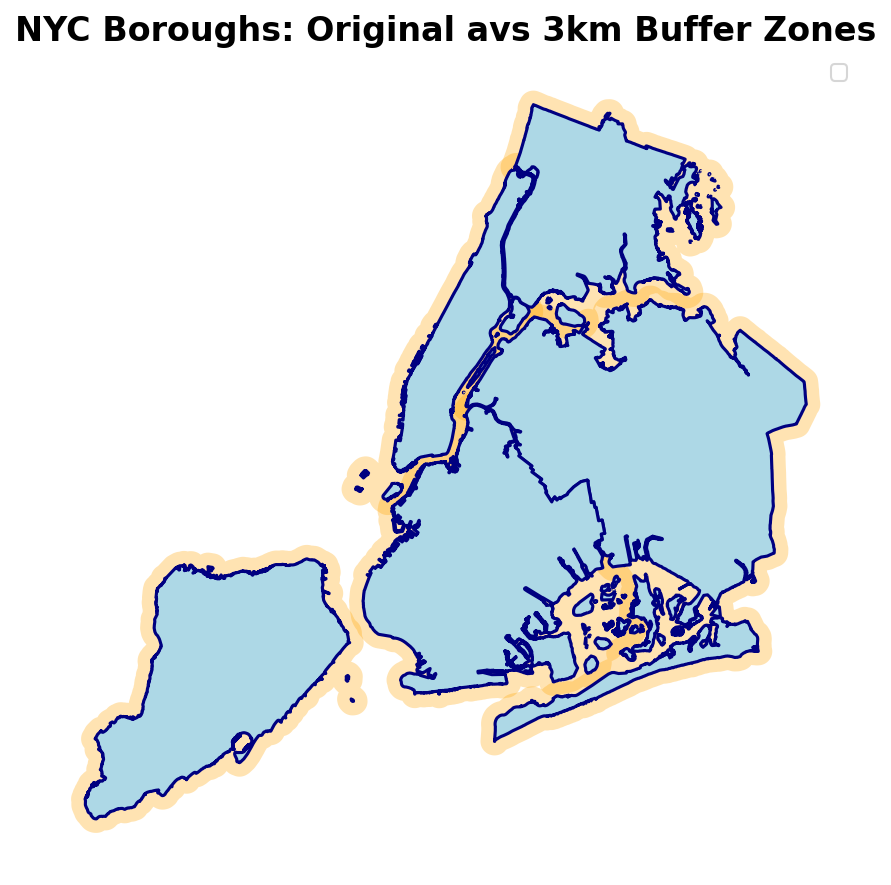

In [18]:
fig, ax = plt.subplots(figsize = (10,6))

#plotting buffered areas firs

gdf["buffered"].plot(
    ax=ax,
    alpha=0.3,
    color="orange",
    linewidth = 1,
    label="3km buffer zones",
)

#original geometries on top
gdf["geometry"].plot(
    ax=ax,
    color="lightblue",
    edgecolor="navy",
    linewidth=1.5,
    label="Original Boundaries",
)

plt.title("NYC Boroughs: Original avs 3km Buffer Zones",fontsize=16,fontweight="bold")
plt.legend(loc="upper right")
plt.axis("off")
plt.tight_layout()
plt.show()

Now to visualize the relatopnship between original shapes and their convex hulls

In [28]:
gdf["convex_hull"] = gdf.convex_hull

#now onto find convex hull area so we can determine the ratio, this will be useful
gdf["convex_hull_area"] = gdf["convex_hull"].area / 1_000_000 #convert to km²
gdf["area_ratio"] = gdf["convex_hull_area"] / gdf["area_km2"]

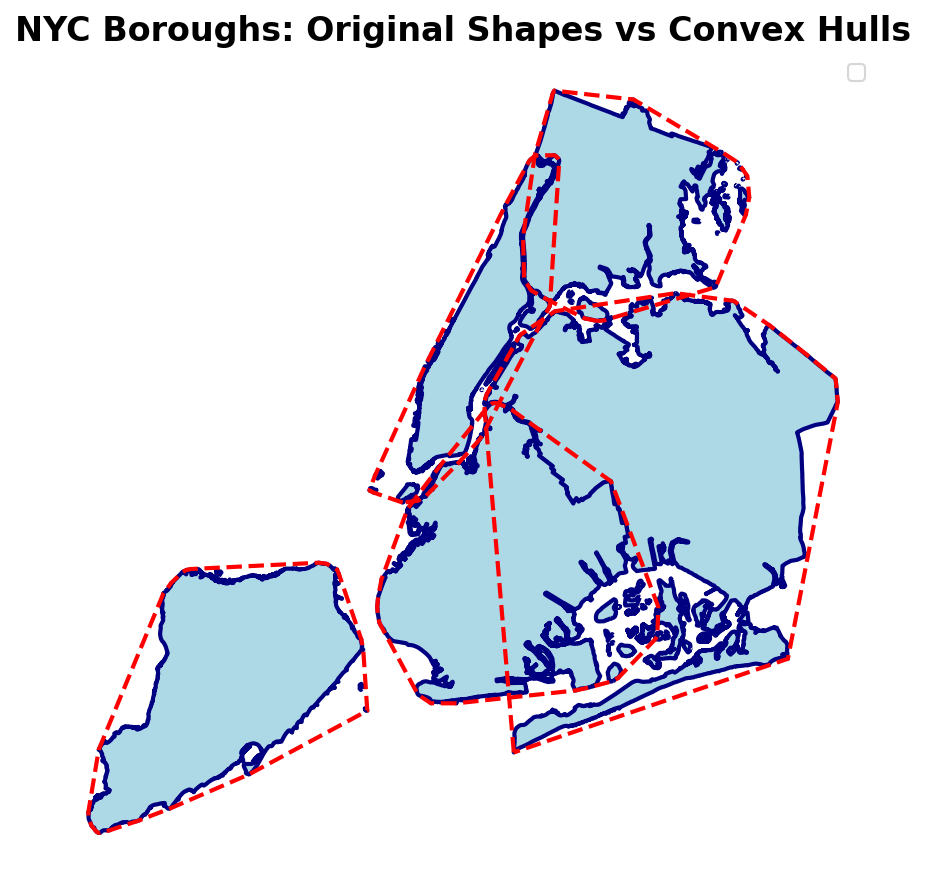

In [26]:

fig, ax = plt.subplots(figsize=(10,6))

gdf["geometry"].plot(
    ax=ax, color="lightblue",edgecolor="navy",linewidth=2,label="Original Shape"
)

#now  to polot convex hulls as outlines
gdf["convex_hull"].plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=2,
    linestyle="--",
    label="Convex Hull"
)

plt.title(
    "NYC Boroughs: Original Shapes vs Convex Hulls",fontsize=16,
    fontweight="bold"
)
plt.legend(loc= "upper right")
plt.axis("off")
plt.tight_layout()
plt.show()

gdf.convex_hull represents the smallest convex shape that can enclose a geometry,
THIS IS USEFUL FOR SHAPE ANALYSIS AND/OR SPATIAL INDEXING

In [32]:
gdf[["BoroName","area_ratio"]].head()

BoroName  area_ratio
0  Staten Island    1.270287
1         Queens    1.717228
2       Brooklyn    1.295149
3      Manhattan    1.726247
4          Bronx    1.397325

Area ratio reveals shape complexity, thus values close to 1.0 indicate relatively simple, convex shapes, whilst smaller ratios suggest mroe complex,irregular boundaries.

For example, looking at Queens vs Staten Islan we can clearly see state island lies comfortably within the dorito whislt queens, the actual area vs the required convex hull shape is more disproportionate, essentially, how much more area from the convex hull is needed relative to the actual area of the region


<span style="font-size:20px"></span>

<span style="font-size:20px">

Intersection Analysis


</span>
Useful for findindg "which areas overlap? or "What falls within a specific zone?"

In [43]:
#first make a mask cause rawdogging "Queens" is nonsence
gdf["boro_clean"] = gdf["BoroName"].str.strip().str.lower()
mask=gdf["boro_clean"] == "queens"
#use the gdf.loc[mask,"geometry"].iloc[0] which has mask look for roq queens and "geometry" for column geometry, if there weere mulitple queens rows iloc[0] enusres we select the first of these
queens_geom = gdf.loc[mask, "geometry"].iloc[0]

gdf["intersects_queens"] = gdf["buffered"].intersects(queens_geom)
gdf["touches_queens"] = gdf["geometry"].touches(queens_geom)

intersection_results = gdf[["intersects_queens","touches_queens"]]
intersection_results

intersects_queens  touches_queens
0              False           False
1               True           False
2               True            True
3               True            True
4               True            True

<span style="font-size:20px">

Containement and Spatial Validation


</span>
Spatial containment is for VERIFYING expected relationships and validating data quality

In [44]:
gdf["centroid_within_borough"]=gdf["centroid"].within(gdf["geometry"]) #we checking for trues and falses given a centroid and its geometry attribute

#how to check for anomalies
anomalies = gdf[~gdf["centroid_within_borough"]]
if len(anomalies) > 0:
    print("Warning: Some centroids fall outrside their borough boundaries")
    print(anomalies.index.tolis())
else:
    print("All centroids correctly fall within their borough boundaries")

All centroids correctly fall within their borough boundaries


<span style="font-size:20px">

Best practice for performance


</span>


Always check CRS when loading new datasets


In [ ]:
#example:
#Reading a GeoJSON File
url = "https://github.com/opengeos/datasets/releases/download/vector/nybb.geojson"
gdf = gpd.read_file(url)
gdf.head()
##------------------LETS CHECK THE CRS (PROJECTION CODE/STANDARD)------------
gdf = gdf.to_crs("EPSG:3857")
#bonus: if using typical region names as your indicator rather than the standard-
#numbering, do this: 
gdf = gdf.set_index("BoroName") #in our case that's the BoroName, could be kommune or bydel though
#this will allow us to gdf.loc["Queens"] (row access) instead of needing to know gdf.loc[0] => Queens
print(f"Now using CRS: {gdf.crs}")

Now using CRS: EPSG:3857


Use appropriate projection given analysis type,
for geographic projection for global visualizaiton, projected for measurements

DOCUMENT COORDINATE SYSTEMS in analysis workflow

CRS defines how the 2D, flat representation of the Earth (a map) corresponds to real-world locations.

Some CRSs use degrees (e.g., latitude/longitude in EPSG:4326), while others use meters ( EPSG:3857 or EPSG:2263).

For calculations like area, distance, or buffering, you need a CRS with projected units (e.g., meters or feet), not geographic units (degrees).

Lots of data sets can come in different CRS', it's useful to reproject them to the same CRS such that the work done is meaningful, less error-prone and replicable

WHEN LOADING DATA, MAKE SURE YOU ALWAYS CHECK ITS CRS, COULD BE NICE TO MAKE A SMALL PYTHON MODULE THAT CHECKS FOR THIS? (Unless it exists)

<span style="font-size:25px">


On Memory and Performance


</span>
filter data early

use spatial indexing (.intersects, .within, .contains)

choose appropriate geometric precision for analysis needs

eg. gdf.geometry.simplify( tolerance , preserve_topology=True )


In [94]:
# NR 1 Load the dataset
url = "https://github.com/opengeos/datasets/releases/download/places/nyc_buildings.geojson"

gdf = gpd.read_file(url)
gdf.head()


fid  height_MS  height_FM  height_avg  SQMETERS STATEFP      NAME  \
0    2      15.05      23.30       19.18   6365.72      36  New York   
1    4      23.62      46.18       34.90   3287.84      36  New York   
2    5      19.98     109.60       64.79   2011.21      36  New York   
3    9      18.50      18.18       18.34   3110.32      36  New York   
4   34      21.53      32.84       27.18   5240.89      36  New York   

                                            geometry  
0  POLYGON ((-74.00129 40.71992, -74.00061 40.719...  
1  POLYGON ((-74.0032 40.71654, -74.00265 40.7163...  
2  POLYGON ((-74.01415 40.70324, -74.01342 40.703...  
3  POLYGON ((-73.98974 40.71924, -73.98924 40.720...  
4  POLYGON ((-74.00941 40.72351, -74.00816 40.723...

In [95]:


#NR 2 DO ALL THE PRO - TIPS FIRST

#checking CRS
print(f"the imported dataset's crs is: {gdf.crs}")
print(f"THAT MEANS LATITUDE AND LONGDITUDE, degreees blud")

#simplify the geometry
#tolerance = 100
#gdf = gdf.simplify(tolerance,preserve_topology=True)
#-----------DONT ALWAYS SIMPLIFY, U CAN LOSE COLUMNS ----
#let's take a look at it
gdf.head()


the imported dataset's crs is: EPSG:4326
THAT MEANS LATITUDE AND LONGDITUDE, degreees blud


fid  height_MS  height_FM  height_avg  SQMETERS STATEFP      NAME  \
0    2      15.05      23.30       19.18   6365.72      36  New York   
1    4      23.62      46.18       34.90   3287.84      36  New York   
2    5      19.98     109.60       64.79   2011.21      36  New York   
3    9      18.50      18.18       18.34   3110.32      36  New York   
4   34      21.53      32.84       27.18   5240.89      36  New York   

                                            geometry  
0  POLYGON ((-74.00129 40.71992, -74.00061 40.719...  
1  POLYGON ((-74.0032 40.71654, -74.00265 40.7163...  
2  POLYGON ((-74.01415 40.70324, -74.01342 40.703...  
3  POLYGON ((-73.98974 40.71924, -73.98924 40.720...  
4  POLYGON ((-74.00941 40.72351, -74.00816 40.723...

In [96]:
#hmmmm, might have to go to a better crs, let's transform it
print("Transforming the crs from: {gdf.crs} to EPSG 3857 (meters)")
gdf = gdf.to_crs("EPSG:3857")

gdf.head()


Transforming the crs from: {gdf.crs} to EPSG 3857 (meters)


fid  height_MS  height_FM  height_avg  SQMETERS STATEFP      NAME  \
0    2      15.05      23.30       19.18   6365.72      36  New York   
1    4      23.62      46.18       34.90   3287.84      36  New York   
2    5      19.98     109.60       64.79   2011.21      36  New York   
3    9      18.50      18.18       18.34   3110.32      36  New York   
4   34      21.53      32.84       27.18   5240.89      36  New York   

                                            geometry  
0  POLYGON ((-8237786.304 4971117.236, -8237710.7...  
1  POLYGON ((-8237998.638 4970621.252, -8237937.1...  
2  POLYGON ((-8239217.225 4968667.347, -8239136.6...  
3  POLYGON ((-8236500.085 4971017.896, -8236444.9...  
4  POLYGON ((-8238689.392 4971645.05, -8238550.15...

Time to create a plot of the buildin footprints and color them based on height

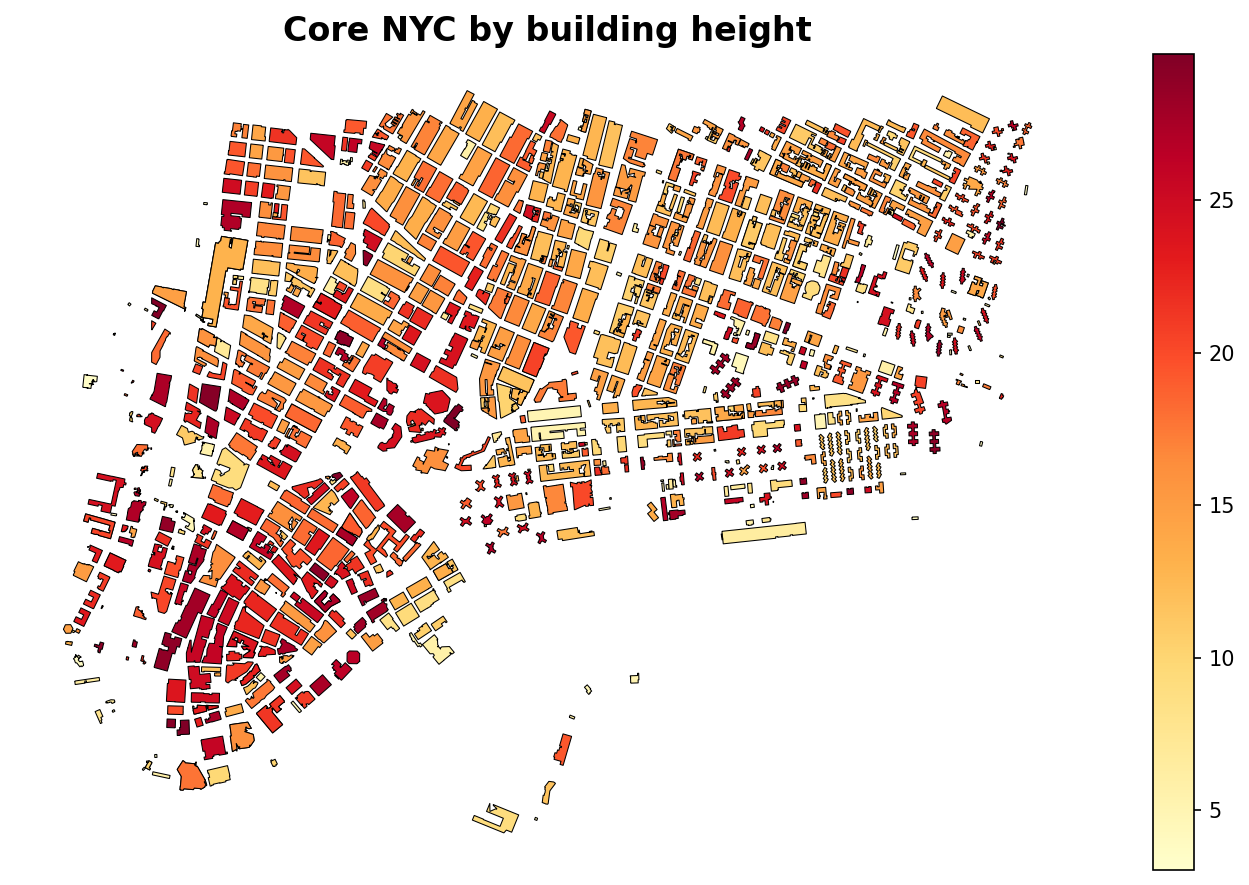

In [98]:
# Create a choropleth map showing borough areas
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(
column="height_MS",
ax=ax,
legend=True,
cmap="YlOrRd", # Yellow-Orange-Red colormap
edgecolor="black",
linewidth=0.5,
)
plt.title("Core NYC by building height", fontsize=16, fontweight="bold")
plt.axis("off") # Remove coordinate axes for cleaner appearance
plt.tight_layout()
plt.show()

INTERACTIVE MAP?!

In [100]:


interactive_map = gdf.explore(
    column="height_MS",
    cmap= "YlOrRd",
    tooltip= ["height_MS","SQMETERS","fid"],
    popup=True,
    legend=True
)
interactive_map


In [104]:
#calculate avg building height

avg_height = gdf["height_MS"].mean()
print(f"The avg. building height in NYC is  {avg_height:.2f} MS") 

The avg. building height in NYC is  15.45 MS


In [ ]:
buildings_higher_than_avg = gdf[(gdf["height_MS"] > avg_height)]
buildings_higher_than_avg.head()



fid  height_MS  height_FM  height_avg  SQMETERS STATEFP      NAME  \
1    4      23.62      46.18       34.90   3287.84      36  New York   
2    5      19.98     109.60       64.79   2011.21      36  New York   
3    9      18.50      18.18       18.34   3110.32      36  New York   
4   34      21.53      32.84       27.18   5240.89      36  New York   
5   38      18.84        NaN       18.84   1151.88      36  New York   

                                            geometry  \
1  POLYGON ((-8237998.638 4970621.252, -8237937.1...   
2  POLYGON ((-8239217.225 4968667.347, -8239136.6...   
3  POLYGON ((-8236500.085 4971017.896, -8236444.9...   
4  POLYGON ((-8238689.392 4971645.05, -8238550.15...   
5  POLYGON ((-8239394.447 4969178.614, -8239352.9...   

                                          avg_height  
1  <bound method Series.mean of 0       15.05\n1 ...  
2  <bound method Series.mean of 0       15.05\n1 ...  
3  <bound method Series.mean of 0       15.05\n1 ...  
4  <bound method Series.mean of 0       15.05\n1 ...  
5  <bound method Series.mean of 0       15.05\n1 ...

In [107]:
#writing geospatial data allows us to save work in different formats which provides flexibility
#for sharing data with different software systems
output_file = "buildings_above_avg_height.geojson"
buildings_higher_than_avg.to_file(output_file,driver= "GeoJSON")
print(f"GeoDataFrame has been writte nto {output_file}")


GeoDataFrame has been writte nto buildings_above_avg_height.geojson
